In [1]:
include("src/shape.jl") 

density_2D

In [2]:
include("src/plotrecipes.jl")

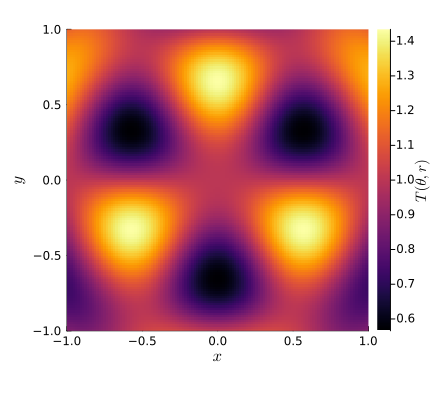

In [3]:
coeff_dict_test = Dict((3, 1) => 1.0)
cfg = SingleConfiguration(coeff_dict_test, 1.0, 128, 128, 0.05, radial_envelope, 1.0)
plot(cfg)

In [4]:
mc = MultipleConfigurations(2, 2, 1.0, 128, 128, 0.05, radial_envelope, 1.0)
plot(mc)

--- 
Use circular vibrating membrane thickness function in the cross section.

In [28]:
include("src/CrossSection.jl")
using .CrossSection

In [29]:
include("src/plotrecipes.jl")
include("src/data.jl")

read_coherent_data (generic function with 1 method)